<a href="https://colab.research.google.com/github/kitty-8910/plant-disease-detection/blob/main/plant_disease_detection_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **VGG WITH TRADITIONAL ML**

In [ ]:
# ==================== Install Required Libraries ====================
!pip install kagglehub scikit-learn pillow opencv-python matplotlib seaborn tqdm

# ==================== Import Libraries ====================
# These imports handle:
# - Data handling: os, numpy, pandas
# - Image reading: PIL
# - Deep learning: torch, torchvision
# - Traditional ML: sklearn
# - Visualization: matplotlib
# - Progress bars: tqdm
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import kagglehub

In [ ]:
# You’re using three plant disease datasets from Kaggle:
# 1. Crop Pest and Disease Detection
# 2. Crop Disease Detection Dataset
# 3. 20k Multi-class Crop Disease Images
# Each dataset has images organized in folders per class (healthy/diseased/etc.).

# Define dataset folder paths (these will vary based on your Kaggle input setup)
print("Downloading datasets...")
path1 = kagglehub.dataset_download("nirmalsankalana/crop-pest-and-disease-detection")
path2 = kagglehub.dataset_download("snikhilrao/crop-disease-detection-dataset")
path3 = kagglehub.dataset_download("jawadali1045/20k-multi-class-crop-disease-images")

print(f"Dataset 1: {path1}")
print(f"Dataset 2: {path2}")
print(f"Dataset 3: {path3}")

Dataset 1: /root/.cache/kagglehub/datasets/nirmalsankalana/crop-pest-and-disease-detection/versions/1
Dataset 2: /root/.cache/kagglehub/datasets/snikhilrao/crop-disease-detection-dataset/versions/1
Dataset 3: /root/.cache/kagglehub/datasets/jawadali1045/20k-multi-class-crop-disease-images/versions/1


In [ ]:
# Function to scan folders, collect all image file paths, and extract their class label (folder name)
def collect_images(base_path):
    """Collect all image paths and labels"""
    data = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):# include only image files
                data.append({
                    'path': os.path.join(root, file),
                    'label': os.path.basename(root)   # label = folder name
                })
    return data

# Combine all datasets
all_data = []
all_data.extend(collect_images(path1))
all_data.extend(collect_images(path2))
all_data.extend(collect_images(path3))
# Print dataset statistics
df = pd.DataFrame(all_data)
print(f"\nTotal images: {len(df)}")
print(f"Number of classes: {df['label'].nunique()}")
print(f"\nTop 10 classes:\n{df['label'].value_counts().head(10)}")


Total images: 110954
Number of classes: 97

Top 10 classes:
label
Tomato septoria leaf spot          2743
Cassava bacterial blight           2614
Apple - Apple Scab                 2520
Apple - Healthy                    2510
Bell Pepper - Healthy              2485
Apple - Black Rot                  2484
Tomato - Yellow Leaf Curl Virus    2451
Potato - Late Blight               2424
Potato - Early Blight              2424
Tomato - Healthy                   2407
Name: count, dtype: int64


In [ ]:
def extract_features(img_path, size=(64, 64)):
    #Simple feature extraction: just resize and flatten the image
    #This is the simplest approach - treating pixels as features
    try:
        img = Image.open(img_path).convert('RGB')
        img = img.resize(size)
        img_array = np.array(img)
        # Flatten: convert 64x64x3 to 12288 features
        features = img_array.flatten()
        return features
    except:
        return None

print("Feature extraction function ready!")
print(f"Each image will be converted to {64*64*3} features")

Feature extraction function ready!
Each image will be converted to 12288 features


In [ ]:
print("\nExtracting features from all images...")
print("This may take 10-20 minutes depending on dataset size...")

features_list = []
labels_list = []
# Iterate through each row in the dataframe
for idx, row in tqdm(df.iterrows(), total=len(df)):
    # Extract features from the image path in the current row
    features = extract_features(row['path'])
    # If feature extraction was successful (features is not None)
    if features is not None:
        # Append the extracted features and the corresponding label to the lists
        features_list.append(features)
        labels_list.append(row['label'])
# Convert the lists of features and labels into NumPy arrays
X = np.array(features_list)
y = np.array(labels_list)

print(f"\nFeature extraction complete!")
print(f"Feature shape: {X.shape}")
print(f"Labels shape: {y.shape}")


Extracting features from all images...
This may take 10-20 minutes depending on dataset size...


 84%|████████▎ | 92895/110954 [05:29<02:34, 116.70it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 89%|████████▉ | 98688/110954 [06:39<00:42, 291.07it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 110954/110954 [09:44<00:00, 189.84it/s]



Feature extraction complete!
Feature shape: (110860, 12288)
Labels shape: (110860,)


In [ ]:
# Initialize and fit the LabelEncoder to transform string labels to numerical format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Label encoding complete!")

Number of classes: 97
Label encoding complete!


In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded # Stratify to maintain class distribution
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 88688
Testing samples: 22172


In [ ]:
print("\nTraining Random Forest Classifier...")

# Initialize the Random Forest Classifier model
# n_estimators: number of trees in the forest
# max_depth: maximum depth of each tree
# random_state: seed for reproducibility
# n_jobs: number of CPU cores to use (-1 means all available)
# verbose: controls the verbosity of the training process
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Train the model using the training data
model.fit(X_train, y_train)

print("\nTraining complete!")


Training Random Forest Classifier...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.6min


building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 25.2min finished



Training complete!


In [ ]:
print("\nEvaluating model on test set...")

# Make predictions on the test set
y_pred = model.predict(X_test)
# Calculate the accuracy of the model on the test set
accuracy = accuracy_score(y_test, y_pred)

print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

print("\nClassification Report:")
# Print a classification report showing precision, recall, f1-score for each class
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Evaluating model on test set...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.1s



Test Accuracy: 0.5939
Test Accuracy: 59.39%

Classification Report:
                                     precision    recall  f1-score   support

                 .ipynb_checkpoints       0.00      0.00      0.00         1
        American Bollworm on Cotton       0.50      0.29      0.37        17
              Anthracnose on Cotton       1.00      0.25      0.40         8
                 Apple - Apple Scab       0.71      0.64      0.67       504
                  Apple - Black Rot       0.78      0.69      0.73       497
           Apple - Cedar Apple Rust       0.77      0.58      0.66       440
                    Apple - Healthy       0.65      0.69      0.67       502
                          Army worm       1.00      0.44      0.61        78
         Bacterial Blight in cotton       1.00      0.39      0.56        57
           Becterial Blight in Rice       0.59      0.95      0.73       321
       Bell Pepper - Bacterial Spot       0.67      0.53      0.59       478
      

[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.3s finished
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(

In [ ]:
print("\nSaving models...")
os.makedirs('models', exist_ok=True)

# Save the trained Random Forest model to a file
pickle.dump(model, open('models/random_forest.pkl', 'wb'))
# Save the fitted LabelEncoder to a file
pickle.dump(label_encoder, open('models/label_encoder.pkl', 'wb'))

print("Models saved successfully!")
print("- models/random_forest.pkl")
print("- models/label_encoder.pkl")


Saving models...
Models saved successfully!
- models/random_forest.pkl
- models/label_encoder.pkl


In [ ]:
def predict_disease(image_path):
    """Predict disease from a leaf image"""
    # Load models
    model = pickle.load(open('models/random_forest.pkl', 'rb'))
    label_encoder = pickle.load(open('models/label_encoder.pkl', 'rb'))

    # Extract features
    features = extract_features(image_path)
    if features is None:
        return None, None

    # Predict
    features = features.reshape(1, -1)
    prediction = model.predict(features)[0]
    probabilities = model.predict_proba(features)[0]
    confidence = np.max(probabilities)

    # Get disease name
    disease = label_encoder.inverse_transform([prediction])[0]

    return disease, confidence

print("Prediction function ready!")

Prediction function ready!


In [ ]:
print("\nTesting predictions on random test images...")

# Get some random test indices
test_indices = np.random.choice(len(X_test), min(5, len(X_test)), replace=False)

for idx in test_indices:
    # Get the actual image path from original dataframe
    test_img_path = df.iloc[idx]['path']
    true_label = label_encoder.inverse_transform([y_test[idx]])[0]

    predicted_disease, confidence = predict_disease(test_img_path)

    print(f"\n{'='*60}")
    print(f"Image: {os.path.basename(test_img_path)}")
    print(f"True Label: {true_label}")
    print(f"Predicted: {predicted_disease}")
    print(f"Confidence: {confidence*100:.2f}%")
    print(f"Correct: {'✓' if true_label == predicted_disease else '✗'}")


Testing predictions on random test images...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished



Image: streak virus201_.jpg
True Label: Strawberry - Healthy
Predicted: Maize leaf beetle
Confidence: 7.82%
Correct: ✗


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished



Image: grasshoper317_.jpg
True Label: Wheat aphid
Predicted: Maize grasshoper
Confidence: 31.29%
Correct: ✗


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished



Image: brown spot896_.jpg
True Label: Strawberry - Healthy
Predicted: Cassava brown spot
Confidence: 20.57%
Correct: ✗


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished



Image: septoria leaf spot1491_.jpg
True Label: Cashew leaf miner
Predicted: Tomato septoria leaf spot
Confidence: 68.54%
Correct: ✗


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished



Image: leaf curl247_.jpg
True Label: Becterial Blight in Rice
Predicted: Tomato septoria leaf spot
Confidence: 56.35%
Correct: ✗


In [ ]:
# Make a prediction on a specific image and print the result
predicted_disease, confidence = predict_disease('/content/leaf2.jpg')
print(f'Disease: {predicted_disease}')
print(f'Confidence: {confidence*100:.2f}%')

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)
print(f"Model Accuracy: {accuracy*100:.2f}%")

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


Disease: Cassava bacterial blight
Confidence: 7.28%

TRAINING COMPLETE!
Model Accuracy: 59.39%


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_job

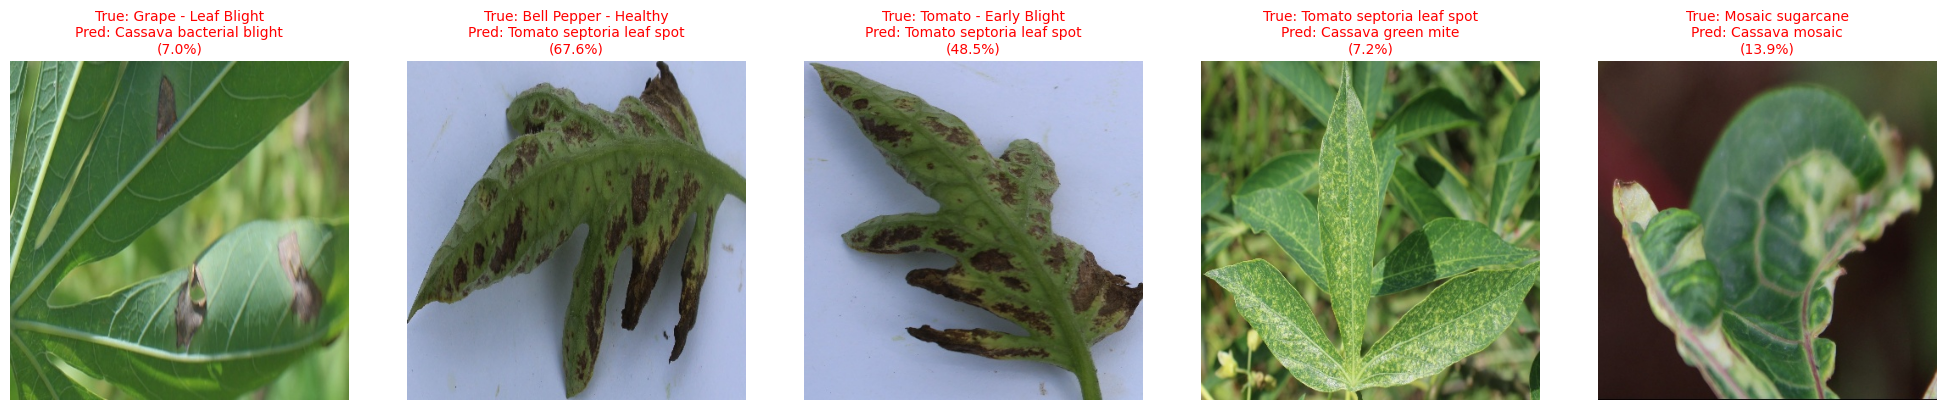

Visualization saved as 'predictions_sample.png'


In [ ]:
def visualize_predictions(num_samples=5):
    """Visualize predictions with images"""
    # Choose random indices from the test set for visualization
    indices = np.random.choice(len(X_test), min(num_samples, len(X_test)), replace=False)

    # Create a figure and axes for plotting the images
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    # If only one sample is requested, axes is not an array, so make it a list
    if num_samples == 1:
        axes = [axes]

    # Iterate through the selected indices
    for i, idx in enumerate(indices):
        # Get the image path and true label from the original dataframe using the index
        img_path = df.iloc[idx]['path']
        true_label = label_encoder.inverse_transform([y_test[idx]])[0]
        # Make a prediction using the trained model
        pred_label, conf = predict_disease(img_path)

        # Open and display the image
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis('off') # Turn off axes

        # Set the title with true and predicted labels and confidence
        # Color the title green if prediction is correct, red otherwise
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\n({conf*100:.1f}%)',
                         color=color, fontsize=10)

    # Adjust layout to prevent titles from overlapping
    plt.tight_layout()
    # Save the visualization to a file
    plt.savefig('predictions_sample.png', dpi=150, bbox_inches='tight')
    # Display the plot
    plt.show()
    print("Visualization saved as 'predictions_sample.png'")

# Visualize predictions for 5 random test images
visualize_predictions(5)

# **VGG WITH DEEP LEARNING**

In [ ]:
!pip install torch torchvision kagglehub pillow matplotlib tqdm
# These imports handle:
# - Data handling: os, numpy, pandas
# - Image reading: PIL
# - Deep learning: torch, torchvision
# - Traditional ML: sklearn
# - Visualization: matplotlib
# - Progress bars: tqdm
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
# We check if CUDA (NVIDIA GPU) is available for faster training.
# If not, it falls back to CPU — slower but still works fine.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")

Using: cuda


In [ ]:
# Used three plant disease datasets from Kaggle:
# 1. Crop Pest and Disease Detection
# 2. Crop Disease Detection Dataset
# 3. 20k Multi-class Crop Disease Images
# Each dataset has images organized in folders per class (healthy/diseased/etc.).

# Define dataset folder paths (these will vary based on your Kaggle input setup)
path1 = kagglehub.dataset_download("nirmalsankalana/crop-pest-and-disease-detection")
path2 = kagglehub.dataset_download("snikhilrao/crop-disease-detection-dataset")
path3 = kagglehub.dataset_download("jawadali1045/20k-multi-class-crop-disease-images")
# Function to scan folders, collect all image file paths, and extract their class label (folder name)
def collect_images(path):
    data = []
    for root, _, files in os.walk(path):
        for f in files:
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                data.append({'path': os.path.join(root, f), 'label': os.path.basename(root)})
    return data

df = pd.DataFrame(collect_images(path1) + collect_images(path2) + collect_images(path3))
print(f"Total: {len(df)} images, {df['label'].nunique()} classes")

Using Colab cache for faster access to the 'crop-pest-and-disease-detection' dataset.


100%|██████████| 1.01G/1.01G [00:14<00:00, 76.9MB/s]

Extracting files...


100%|██████████| 2.34G/2.34G [00:18<00:00, 136MB/s]

Extracting files...


Total: 110954 images, 97 classes


In [ ]:
# Convert string class names (e.g., "Apple___healthy") to numeric indices.
# This is needed for model training and evaluation.
labels = sorted(df['label'].unique())
label_to_idx = {l: i for i, l in enumerate(labels)}
idx_to_label = {i: l for l, i in label_to_idx.items()}
df['label_idx'] = df['label'].map(label_to_idx)
# Split dataset into 80% training and 20% testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label_idx'])
print(f"Train: {len(train_df)}, Test: {len(test_df)}")

Train: 88763, Test: 22191


In [ ]:
# This class allows PyTorch to load images efficiently in batches.
# It reads image paths from the dataframe, applies transformations,
# and returns an image tensor along with its label index.
class CropDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            img = Image.open(self.df.loc[idx, 'path']).convert('RGB')
            return self.transform(img), self.df.loc[idx, 'label_idx']
        except:
            # If image is corrupted, return a random valid image
            new_idx = np.random.randint(0, len(self.df))
            return self.__getitem__(new_idx)

# We resize all images to 224x224 pixels (the standard input size for VGG).
# Normalization uses ImageNet’s mean and standard deviation, matching the pretrained model.
# Training data also has random augmentations (flips, rotations) to make the model robust.

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# DataLoaders efficiently read and batch images during training.
# Shuffle is True for training to randomize batches, and False for testing.
train_loader = DataLoader(CropDataset(train_df, train_transform), batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(CropDataset(test_df, test_transform), batch_size=32, shuffle=False, num_workers=0)

In [ ]:
def train_eval(model, train_loader, test_loader, epochs=5):
    # Define the loss function (Cross-Entropy Loss is common for classification)
    criterion = nn.CrossEntropyLoss()
    # Define the optimizer (Adam is a good choice) and specify which parameters to update
    # We are only training the last layer (classifier[6]) of the VGG model
    optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)

    # Loop through the specified number of training epochs
    for epoch in range(epochs):
        # Set the model to training mode
        model.train()
        # Iterate over the training data loader in batches
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            # Move images and labels to the specified device (GPU or CPU)
            images, labels = images.to(device), labels.to(device)
            # Zero the gradients to prevent accumulation from previous batches
            optimizer.zero_grad()
            # Forward pass: compute the model's output (logits)
            outputs = model(images)
            # Calculate the loss
            loss = criterion(outputs, labels)
            # Backward pass: compute gradients
            loss.backward()
            # Update model parameters
            optimizer.step()

        # Set the model to evaluation mode
        model.eval()
        correct = total = 0
        # Disable gradient calculation during evaluation
        with torch.no_grad():
            # Iterate over the test data loader in batches
            for images, labels in test_loader:
                # Move images and labels to the device
                images, labels = images.to(device), labels.to(device)
                # Forward pass
                outputs = model(images)
                # Get the predicted class (the one with the highest probability)
                _, preds = torch.max(outputs, 1)
                # Update total number of samples
                total += labels.size(0)
                # Update number of correct predictions
                correct += (preds == labels).sum().item()

    # Calculate and return the accuracy
    return 100 * correct / total

In [ ]:
print("\nTraining VGG16...")
# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)
# Freeze all the layers except the final classifier layer
for p in vgg16.parameters():
    p.requires_grad = False
# Replace the final classifier layer with a new linear layer with the number of output classes
vgg16.classifier[6] = nn.Linear(4096, len(labels))
# Move the model to the specified device (GPU or CPU)
vgg16 = vgg16.to(device)

# Train and evaluate the VGG16 model
acc16 = train_eval(vgg16, train_loader, test_loader)
print(f"VGG16 Accuracy: {acc16:.2f}%")


Training VGG16...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5:  52%|█████▏    | 1452/2774 [05:08<05:23,  4.09it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Epoch 1/5:  81%|████████  | 2234/2774 [07:47<01:51,  4.82it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images wi

VGG16 Accuracy: 81.73%


In [ ]:
print("\nTraining VGG19...")
# Load the pre-trained VGG19 model
vgg19 = models.vgg19(pretrained=True)
# Freeze all the layers except the final classifier layer
for p in vgg19.parameters():
    p.requires_grad = False
# Replace the final classifier layer with a new linear layer with the number of output classes
vgg19.classifier[6] = nn.Linear(4096, len(labels))
# Move the model to the specified device (GPU or CPU)
vgg19 = vgg19.to(device)

# Train and evaluate the VGG19 model
acc19 = train_eval(vgg19, train_loader, test_loader)
print(f"VGG19 Accuracy: {acc19:.2f}%")


Training VGG19...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:06<00:00, 87.1MB/s]
Epoch 5/5: 100%|██████████| 2774/2774 [09:36<00:00,  4.81it/s]


VGG19 Accuracy: 81.53%


In [ ]:
# Compare the accuracies of VGG16 and VGG19 and select the best model
best_model, best_name, best_acc = (vgg16, "VGG16", acc16) if acc16 > acc19 else (vgg19, "VGG19", acc19)
print(f"\nBest: {best_name} ({best_acc:.2f}%)")

# Create a directory named 'models' if it doesn't exist
os.makedirs('models', exist_ok=True)
# Save the state dictionary of the best model, label mapping, and model name to a file
torch.save({'model': best_model.state_dict(), 'labels': idx_to_label, 'name': best_name}, 'models/best.pth')
print("Model saved!")


Best: VGG16 (81.73%)
Model saved!


In [ ]:
def predict(image_path):
    # Load the saved model checkpoint
    ckpt = torch.load('models/best.pth', map_location=device)
    # Initialize the model based on the saved name (VGG16 or VGG19)
    model = models.vgg16() if ckpt['name'] == 'VGG16' else models.vgg19()
    # Replace the final classifier layer with a new linear layer with the correct number of output classes
    model.classifier[6] = nn.Linear(4096, len(ckpt['labels']))
    # Load the saved model state dictionary
    model.load_state_dict(ckpt['model'])
    # Move the model to the device and set it to evaluation mode
    model = model.to(device).eval()

    # Load and transform the input image
    img = test_transform(Image.open(image_path).convert('RGB')).unsqueeze(0).to(device)
    # Disable gradient calculation for inference
    with torch.no_grad():
        # Compute probabilities using softmax
        probs = torch.softmax(model(img), 1)
        # Get the predicted class and its confidence
        conf, pred = torch.max(probs, 1)

    # Return the predicted label and confidence
    return ckpt['labels'][pred.item()], conf.item()

# Test the prediction function on random images from the test set
for _, row in test_df.sample(3).iterrows():
    disease, conf = predict(row['path'])
    print(f"True: {row['label']} | Pred: {disease} ({conf*100:.1f}%)")

print("\n✅ Done! Use: predict('image.jpg')")

True: Cotton Aphid | Pred: Cotton Aphid (73.3%)
True: Peach - Bacterial Spot | Pred: Peach - Bacterial Spot (100.0%)
True: Apple - Healthy | Pred: Apple - Healthy (99.6%)

✅ Done! Use: predict('image.jpg')
